## 1.0 Importing Packages

In [109]:
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

## 2.0 Reading & Exploring Data

### 2.1 Reading Data

In [110]:
df = pd.read_csv("../inputs/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### 2.2 Plotting targets distribution

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


<AxesSubplot:>

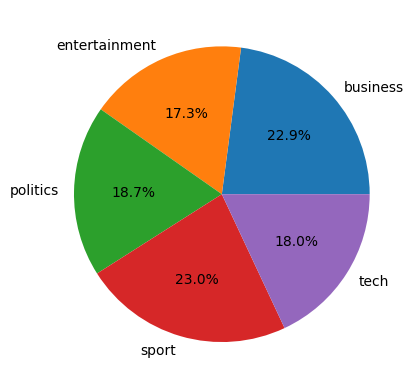

In [112]:
print(df['category'].value_counts())
df.groupby('category').size().plot(kind='pie',
                                   y="category",
                                   label="",
                                   autopct='%1.1f%%')

## 3.0 Preprocessing Data

### 3.1 Converting targets to one hot vectors

In [113]:
targets = np.array(pd.get_dummies(df['category']))

### 3.2 Cleaning and Preprocessing text

In [114]:
def clean_text(text: str) -> str:
  """
  Clean & preprocess `text` including:
  - removing any mentions
  - removing any links
  - removing any hashtags
  - removing quotation marks
  - removing digits and words containing digits
  - removing ant consecutive spaces

  Parameters:
  ------------
  - text : str
    Text needed to be processed
    
  Returns:
  --------
  - cleaned_text : str
    A cleaned version of passed `text`
  """

  text = re.sub("@\S+", " ", text)
  text = re.sub("https*\S+", " ", text)
  text = re.sub("#\S+", " ", text)
  text = re.sub("\'\w+", '', text)
  text = re.sub(r'\w*\d+\w*', '', text)
  cleaned_text = re.sub('\s{2,}', " ", text).strip()

  return cleaned_text

In [115]:
df['clean_text'] = df['text'].apply(clean_text)

## 4.0 Splitting Data to training and testing parts

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], targets, test_size=0.2, stratify=df['category'])

In [117]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1780,)
y_train shape: (1780, 5)
X_test shape: (445,)
y_test shape: (445, 5)


### Saving Data to be comparable with GRU

In [118]:
pd.DataFrame(X_train).to_csv("../inputs/X_train.csv")
pd.DataFrame(X_test).to_csv("../inputs/X_test.csv")
pd.DataFrame(y_train).to_csv("../inputs/y_train.csv")
pd.DataFrame(y_test).to_csv("../inputs/y_test.csv")

## 5.0 Preparing Data

In [120]:
max_vocab = 2000
maxlen = 256

In [121]:
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [122]:
X_train_vectors = tokenizer.texts_to_sequences(X_train)
X_train_vectors = pad_sequences(X_train_vectors, maxlen=maxlen, padding='post', truncating='post')

In [123]:
with open('../tokenizers/lstm_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [124]:
X_test_vectors = tokenizer.texts_to_sequences(X_test)
X_test_vectors = pad_sequences(X_test_vectors, maxlen=maxlen, padding='post', truncating='post')

## 6.0 Model Building

In [125]:
model = keras.Sequential([
    keras.layers.Embedding(
        max_vocab, 16, input_length=maxlen),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(64),
    keras.layers.Dense(5, activation='softmax')
])

In [126]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 16)           32000     
                                                                 
 dropout_9 (Dropout)         (None, 256, 16)           0         
                                                                 
 conv1d (Conv1D)             (None, 252, 64)           5184      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                      

## 7.0 Model Compiling

In [127]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 8.0 Model Training

In [128]:
batch_size = 32
epochs = 20
history = model.fit(X_train_vectors, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vectors, y_test))

Epoch 1/20
56/56 [==============================] - 5s 53ms/step - loss: 1.4801 - accuracy: 0.2966 - val_loss: 1.4669 - val_accuracy: 0.3416
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1775 - accuracy: 0.4073 - val_loss: 1.0916 - val_accuracy: 0.4404
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.0466 - accuracy: 0.4169 - val_loss: 1.0503 - val_accuracy: 0.3955
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 0.9959 - accuracy: 0.4427 - val_loss: 1.0064 - val_accuracy: 0.4697
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 0.8531 - accuracy: 0.5691 - val_loss: 0.8013 - val_accuracy: 0.5933
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 0.7779 - accuracy: 0.6090 - val_loss: 0.7752 - val_accuracy: 0.6067
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 0.6531 - accuracy: 0.6646 - val_loss: 0.7029 - val_accuracy: 0.6427
Epoch 8/20
56

## 9.0 Model's Performance Plotting

### 9.1 Plotting Loss vs. Validation Loss

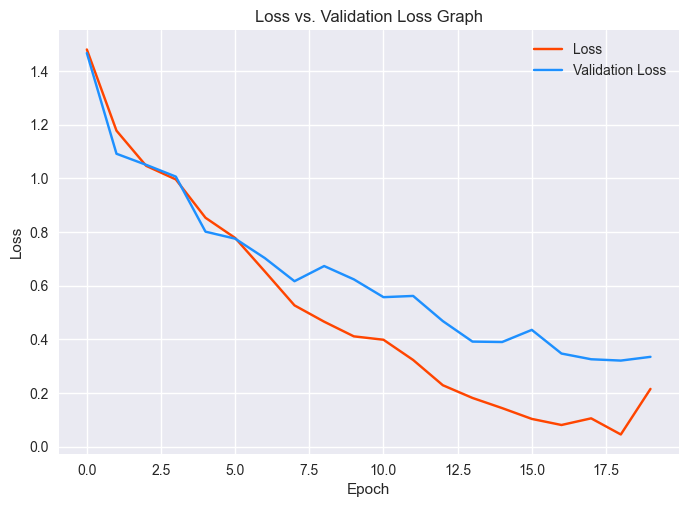

In [129]:
plt.style.use(['seaborn'])
plt.title("Loss vs. Validation Loss Graph")
plt.plot(history.history["loss"], color="orangered", label="Loss")
plt.plot(history.history["val_loss"], color="dodgerblue", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 9.2 Plotting Accuracy vs. Validation Accuracy

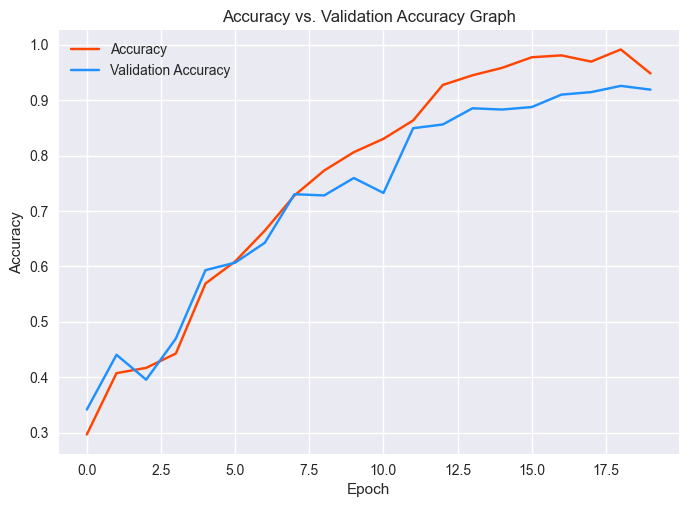

In [130]:
plt.title("Accuracy vs. Validation Accuracy Graph")
plt.plot(history.history["accuracy"], color="orangered", label="Accuracy")
plt.plot(history.history["val_accuracy"], color="dodgerblue", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 9.3 Plotting Classification Report  

In [131]:
predictions = model.predict(X_test_vectors)
preds = np.where(predictions > 0.5, 1, 0)

14/14 [==============================] - 1s 14ms/step


In [132]:
cls_report = classification_report(y_test, preds)
print(cls_report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       102
           1       0.81      0.97      0.88        77
           2       0.95      0.87      0.91        84
           3       1.00      0.90      0.95       102
           4       0.96      0.97      0.97        80

   micro avg       0.92      0.92      0.92       445
   macro avg       0.92      0.92      0.92       445
weighted avg       0.93      0.92      0.92       445
 samples avg       0.92      0.92      0.92       445



### 9.4 Plotting Confusion Matrix

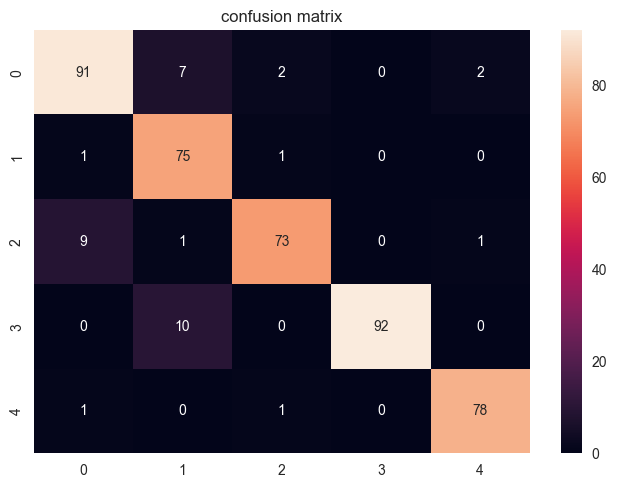

In [133]:
y_test_vector = np.argmax(y_test, axis=1)
y_pred_vector = np.argmax(preds, axis=1)
conf_matrix = confusion_matrix(y_test_vector, y_pred_vector)
sn.heatmap(conf_matrix, annot=True)
plt.title("confusion matrix")
plt.show()

## 10.0 Model Evaluation

In [134]:
loss_and_accuracy = model.evaluate(X_test_vectors, y_test)
print(f"loss: {loss_and_accuracy[0]:.4f}")
print(f"accuracy: {loss_and_accuracy[1]:.4f}")

14/14 [==============================] - 0s 17ms/step - loss: 0.3350 - accuracy: 0.9191
loss: 0.3350
accuracy: 0.9191


## 11.0 Model Saving

In [135]:
model.save("../models/BBC-Classifier-LSTM.h5")